<a href="https://colab.research.google.com/github/yusukeorito/Master_research/blob/main/exp011/notebooks/Exp011_Train_model_001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
問題設定：分類問題
学習データサイズ M：訓練6000、テスト10000
レイヤー数L : 10 or 20
ネットワークの幅N:100
ノイズパラメータλ:1.5
"""

'\n問題設定：分類問題\n学習データサイズ M：訓練6000、テスト10000\nレイヤー数L : 10 or 20\nネットワークの幅N:100\nノイズパラメータλ:1.5\n'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Master_research/exp011

/content/drive/MyDrive/Master_research/exp011


In [ ]:
import os
import random
import pickle

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import Callback,ModelCheckpoint
from tensorflow.keras.layers import Dense,BatchNormalization,Activation
from tensorflow.keras.callbacks import Callback,ModelCheckpoint
from tensorflow.keras.activations import relu
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

class CFG:
    task = 'classification'
    seed1 = 820
    seed2=314
    seed3=1228
    seed4=1229
    data_seed = 42
    save_dir = '../Model/'
    output_dir = '../Output/'
    L=10
    M=60000
    N=100
    #A=1.5#ノイズの強さ
    C=50#結合を持つweightの個数
    ini_type = 'B'
    train='train'
    mean = 0.5  # 平均
    std_dev = 0.1  # 標準偏差
    layer_name_list =['batch_normalization1', 'batch_normalization2', 'batch_normalization3',
                   'batch_normalization4', 'batch_normalization5', 'batch_normalization6', 'batch_normalization7', 'batch_normalization8',
                   'batch_normalization9','batch_normalization10',]

def set_seed(seed):
    tf.random.set_seed(seed)
    # optional
    # for numpy.random
    np.random.seed(seed)
    # for built-in random
    random.seed(seed)
    # for hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)

def preprocess_data(X_train_, y_train_):
    # Rasterize and normalize samples

    X_train_ = X_train_.reshape(X_train_.shape[0], -1)
    y_train_ = y_train_.reshape(y_train_.shape[0], -1)

    X_train_ = X_train_ / 255
    y_train_ = y_train_ / 255

    # Use 32-bit instead of 64-bit float
    X_train_ = X_train_.astype("float32")
    y_train_ = y_train_.astype("float32")

    return X_train_, y_train_

def PCA_SS_func(input_train,input_test):
  input_d=100
  # Make an instance of the Model
  pca = PCA(n_components=input_d)
  scaler = StandardScaler()

  train_img = pca.fit_transform(input_train)
  print(np.sum(pca.explained_variance_ratio_[:]))
  train_img =scaler.fit_transform(train_img)
  test_img = pca.transform(input_test)
  test_img =scaler.transform(test_img)
  print('Train:',train_img.shape)
  print('Test:',test_img.shape)
  return train_img, test_img, pca, scaler



class LogEpochIntermediateCallcack(Callback):
    def __init__(self, layer_name_list, model_num):
        self.layer_name_list = layer_name_list
        self.spin_dict = {key: [] for key in self.layer_name_list}
        self.nextMeas = 1
        self.model_num = model_num

    def on_train_begin(self, batch, logs=None):
        self.spin_dict['time'] = [0]

        for l in self.layer_name_list:
            intermediate_layer_model = tf.keras.Model(inputs=self.model.input, outputs=self.model.get_layer(l).output)

            if CFG.M == 60000:
                intermediate_output = intermediate_layer_model.predict(X_train_)
            else:
                intermediate_output = intermediate_layer_model.predict(X_train)

            tf.keras.backend.clear_session()
            self.spin_dict[l].append(intermediate_output)

    def on_epoch_begin(self, epoch, logs=None):
        self.ep = epoch

    def on_epoch_end(self, batch, logs):
        if self.ep + 1 == self.nextMeas:
            for l in self.layer_name_list:
                intermediate_layer_model = tf.keras.Model(inputs=self.model.input, outputs=self.model.get_layer(l).output)

                if CFG.M == 60000:
                    intermediate_output = intermediate_layer_model.predict(X_train_)
                else:
                    intermediate_output = intermediate_layer_model.predict(X_train)

                tf.keras.backend.clear_session()
                self.spin_dict[l].append(intermediate_output)

            self.spin_dict['time'] += [self.ep + 1]
            self.nextMeas = int(self.nextMeas * 1.1)

            if self.ep + 1 == self.nextMeas:
                self.nextMeas = self.nextMeas + 1


    def on_train_end(self, logs=None):
        for l in self.layer_name_list:
            self.spin_dict[l] = np.array(self.spin_dict[l])

        with open(f'./Output/Spin/M{CFG.M}/model{self.model_num}_stopW_type{CFG.ini_type}_L{CFG.L}_C{CFG.C}_{CFG.train}.txt', 'wb') as handle:
            pickle.dump(self.spin_dict, handle)


def add_gaussian_noise(image, mean, std_dev, alpha):
    noise = np.random.normal(mean, std_dev, image.shape)
    noisy_image = image + alpha * noise
    return np.clip(noisy_image, 0, 1)  # ピクセル値を0から1の範囲にクリップ




class CustomConstraint(tf.keras.constraints.Constraint):
    def __init__(self, mask, const):
        self.mask = mask
        self.const = const

    def __call__(self, w):
        # マスク行列を使用して、指定された部分を0で固定する
        w.assign(tf.math.multiply(w, self.mask) + self.const)
        return w


def get_mask(shape, C, specified_number, dtype=int):
    masks = np.zeros(shape)
    consts = np.random.normal(size=shape)
    for col in range(shape[1]):
        non_zero_indices = np.random.choice(shape[0], C, replace=False)
        masks[non_zero_indices, col] = 1
        consts[non_zero_indices, col] = 0
    masks = tf.constant(masks, dtype=tf.float32)
    consts = tf.constant(consts, dtype=tf.float32)
    return masks, consts




def create_model(params:dict,w_initializer,Mask_list,Const_list):
    """
    Creates a neural network model based on the given parameters.

    Args:
        params (dict): Dictionary containing model parameters.

    Returns:
        tf.keras.Model: Compiled neural network model.
    """
    model = Sequential(name='custom_model')
    model.add(Dense(params['width'], kernel_initializer=w_initializer,bias_initializer=params['bias_initializer'],input_shape=(params['input_size'],), name='Affine1',kernel_constraint=CustomConstraint(mask=Mask_list[0],const=Const_list[0])))
    model.add(BatchNormalization(name='batch_normalization1'))
    model.add(Activation('relu', name='activation1'))
    for i in range(1, params['num_layers'] - 1):
        model.add(Dense(params['width'], kernel_initializer=w_initializer,bias_initializer=params['bias_initializer'],name=f'Affine{i+1}',kernel_constraint=CustomConstraint(mask=Mask_list[i],const=Const_list[i])))
        model.add(BatchNormalization(name=f'batch_normalization{i+1}'))
        model.add(Activation('relu',name=f'activation{i+1}'))

    model.add(Dense(params['output_size'],kernel_initializer=w_initializer,bias_initializer=params['bias_initializer'],name='output',kernel_constraint=CustomConstraint(mask=Mask_list[9],const=Const_list[9])))
    model.add(BatchNormalization(name=f'batch_normalization{params["num_layers"]}'))
    model.add(Activation('softmax', name=f'activation{params["num_layers"]}'))
    model.compile(loss=params['loss'], optimizer='adam',metrics=params['metrics']
                  )
    return model


def calc_q_(A: np.ndarray, B: np.ndarray) -> float:
    M, N = A.shape
    dot_product = np.dot(A.T, B)
    x = np.sum(dot_product ** 2)
    x /= N * M * M
    x -= N / M
    return x

def calc_sim_q(A: np.ndarray, B: np.ndarray) -> float:
  mean = A * B
  sim_q = np.mean(mean)
  return sim_q

def get_sim_q(spinA, spinB):
  qab_dict={'time':spinA['time']}#時刻の初期化
  qaa_dict={'time':spinA['time']}
  sim_q_dict={'time':spinA['time']}
  for l in tqdm(CFG.layer_name_list):
      qab_list=[]
      qaa_list=[]
      sim_q_list=[]
      for i in range(len(spin_A[l])):
          ab = calc_sim_q(spin_A[l][i],spin_B[l][i])
          aa = calc_sim_q(spin_A[l][i],spin_A[l][i])
          bb = calc_sim_q(spin_B[l][i],spin_B[l][i])
          sim_q = ab/(np.sqrt(aa)*np.sqrt(bb))
          qab_list.append(ab)
          qaa_list.append(aa)
          sim_q_list.append(sim_q)
      qab_dict[l] = qab_list
      qaa_dict[l] = qaa_list
      sim_q_dict[l] = sim_q_list
  with open(f'./Output/Overlap/q/M{CFG.M}/sim_q_stopW_ini{CFG.ini_type}_L{CFG.L}_C{CFG.C}_{CFG.train}.txt','wb') as handle:
        pickle.dump(sim_q_dict, handle)
  return sim_q_dict


def get_q2(spinA, spinB):
    qab_dict={'time':spinA['time']}#時刻の初期化
    qaa_dict={'time':spinA['time']}
    q2_dict={'time':spinA['time']}
    for l in tqdm(CFG.layer_name_list):
        qab_list=[]
        qaa_list=[]
        q2_list=[]
        for i in range(len(spinA[l])):
            ab = calc_q_(spinA[l][i],spinB[l][i])
            aa= calc_q_(spinA[l][i],spinA[l][i])
            bb = calc_q_(spinB[l][i],spinB[l][i])
            q2 = ab/(np.sqrt(aa)*np.sqrt(bb))
            qab_list.append(ab)
            qaa_list.append(aa)
            q2_list.append(q2)
        qab_dict[l] = qab_list
        qaa_dict[l] = qaa_list
        q2_dict[l] = q2_list
    """
    with open(f'./Output/Overlap/q/{CFG.alg}_qab_norm_M{CFG.M}_L{CFG.L}_A{CFG.A}_{CFG.train}.txt','wb') as handle:
        pickle.dump(qab_dict, handle)
    with open(f'./Output/Overlap/q/{CFG.alg}_qaa_norm_M{CFG.M}_L{CFG.L}_A{CFG.A}_{CFG.train}.txt','wb') as handle:
        pickle.dump(qaa_dict, handle)
    """
    with open(f'./Output/Overlap/q/M{CFG.M}/q2_stopW_ini{CFG.ini_type}_L{CFG.L}_C{CFG.C}_{CFG.train}.txt','wb') as handle:
        pickle.dump(q2_dict, handle)
    return qab_dict, qaa_dict, q2_dict



def get_layer_overlap(qab:dict,qaa:dict,q2:dict,sim_q:dict):
  layer_dict={}
  layer_q2=[]
  layer_qab=[]
  layer_qaa=[]
  layer_sim_q=[]

  for i, l in enumerate(CFG.layer_name_list):
      layer_q2.append(q2[l][-1])#平衡状態のOverlapを取得
      layer_qab.append(qab[l][-1])
      layer_qaa.append(qaa[l][-1])
      layer_sim_q.append(sim_q[l][-1])
  layer_dict['q2']=layer_q2
  layer_dict['qab']=layer_qab
  layer_dict['qaa']=layer_qaa
  layer_dict['sim_q']=layer_sim_q

  with open(f'./Output/Overlap/Layer_q/M{CFG.M}/layerq_stopW_ini{CFG.ini_type}_L{CFG.L}_C{CFG.C}_{CFG.train}.txt','wb') as handle:
        pickle.dump(layer_dict, handle)
  return layer_dict




def get_normalized_spin(SpinA, SpinB):
  spinA_norm = SpinA.copy()
  spinB_norm = SpinB.copy()
  for l in tqdm(CFG.layer_name_list):
        squared_sum_A = np.sum(SpinA[l]**2, axis=2)
        squared_sum_B = np.sum(SpinB[l]**2, axis=2)
        # 規格化定数を計算
        normalization_constA = np.sqrt(100 / squared_sum_A)
        normalization_constB = np.sqrt(100 / squared_sum_B)
        # 規格化した配列を計算
        spinA_norm[l] = SpinA[l] * normalization_constA[:, :, np.newaxis]
        spinB_norm[l] = SpinB[l] * normalization_constB[:, :, np.newaxis]

  return spinA_norm, spinB_norm



model_params = {
    'num_layers':CFG.L,
    'input_size': 100,#width of network
    'output_size': 10,
    'batch_size':256,
    'width':100,
    'epochs':3000,
    'metrics':'accuracy',
    'loss':'sparse_categorical_crossentropy',
    'activation':'relu',
    'activation_last':'softmax',
    #'weight_initializer': tf.keras.initializers.RandomNormal(mean=0.0, stddev=1),
    'bias_initializer_value': 0.1,
    'bias_initializer': tf.keras.initializers.Constant(0.1),
    'optimizer':'adam',
}

In [ ]:
print('='*15+'Data Load'+'='*15)
set_seed(seed=CFG.data_seed)
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train),(X_test, y_test) = fashion_mnist.load_data()
del fashion_mnist
print(X_train.shape)
print(X_test.shape)

print('='*15+'Preprocess data'+'='*15)
X_train, X_test = preprocess_data(X_train, X_test)


idx = np.random.choice(X_train.shape[0], size=CFG.M, replace=False)
X_train = X_train[idx]
y_train = y_train[idx]
n_classes = len(np.unique(y_train))

print('N_classes:',n_classes)
print('Train size:',X_train.shape, 'Test size:', y_train.shape)


print('='*15+'PCA'+'='*15)
X_train,X_test, pca1, scaler1 = PCA_SS_func(X_train, X_test)
print('Train size after PCA:',X_train.shape, 'Test size after PCA:', X_test.shape)

if CFG.M == 60000:
  print('M=60000')
  idx = np.random.choice(X_train.shape[0], size=6000, replace=False)
  X_train_ = X_train[idx]
  y_train_ = y_train[idx]
  print('X_train for mesure:',X_train_.shape,'y_train for mesure:',y_train_.shape, )

print('='*15+'get_mask'+'='*15)
mask_list = []
const_list = []
for i in range(CFG.L-1):
  mask,const = get_mask(shape=(100,100),C=CFG.C,specified_number=5)
  mask_list.append(mask)
  const_list.append(const)

if CFG.task == 'classification':
  print('='*15+'task is classification'+'='*15)
  mask, const = get_mask(shape=(100,10),C=CFG.C,specified_number=5)
  mask_list.append(mask)
  const_list.append(const)


print('='*15+'Build model1'+'='*15)
if CFG.ini_type == 'A':
  print('initialize type A')
  set_seed(CFG.seed1)
  w_intializer1 = tf.keras.initializers.RandomNormal(mean=0, stddev=1)
elif CFG.ini_type == 'B':
  print('initialize type B')
  set_seed(CFG.seed3)
  w_intializer1 = tf.keras.initializers.RandomNormal(mean=0, stddev=1)

model1 = create_model(params=model_params, w_initializer=w_intializer1,Mask_list=mask_list ,Const_list=const_list)
print(model1.layers[3].get_weights()[0])
"""
print('='*15+'Train model1'+'='*15)
history1 = model1.fit(X_train, y_train,
                batch_size=model_params["batch_size"],
                epochs=model_params["epochs"],
                verbose=1,
                shuffle=True,
                validation_data=(X_test, y_test),
                callbacks=[LogEpochIntermediateCallcack(layer_name_list=CFG.layer_name_list,model_num='001')]
                )

print('='*15+'Save loss and acc'+'='*15)
with open(f'./Output/Loss/M{CFG.M}/perform001_ini{CFG.ini_type}_L{CFG.L}_C{CFG.C}_{CFG.train}.txt','wb') as handle:
        pickle.dump(history1.history, handle)
"""

===============Data Load===============
4422102/4422102 [==============================] - 1s 0us/step
(60000, 28, 28)
(10000, 28, 28)
===============Preprocess data===============
N_classes: 10
Train size: (60000, 784) Test size: (60000,)
===============PCA===============
0.91186124
Train: (60000, 100)
Test: (10000, 100)
Train size after PCA: (60000, 100) Test size after PCA: (10000, 100)
M=60000
X_train for mesure: (6000, 100) y_train for mesure: (6000,)
===============get_mask===============
===============task is classification===============
===============Build model1===============
initialize type B


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


[[-2.2169037e-01  2.5152528e-01  5.3509170e-01 ... -3.1156749e-01
   2.2287710e-01  1.8350242e-01]
 [ 1.2763370e+00  1.5121732e+00 -7.3075229e-01 ... -6.1593682e-01
   2.6053604e-01  1.5594426e-01]
 [-4.2724130e-01 -1.7028670e-01  4.0260607e-01 ... -1.3374084e+00
   7.7650487e-01 -2.1277781e+00]
 ...
 [-1.8695781e-01 -1.0467594e+00 -1.0421997e+00 ...  4.6834043e-01
   3.3366442e-01  1.6493342e+00]
 [ 7.1734779e-02 -2.9102242e-01  1.2172666e+00 ... -7.5133204e-01
  -2.8576047e+00  1.1690609e+00]
 [ 1.6195860e+00 -1.8539562e+00  4.8366028e-01 ...  3.8090289e-01
   4.3907928e-01  1.7404248e-03]]


'\nprint(\'=\'*15+\'Train model1\'+\'=\'*15)\nhistory1 = model1.fit(X_train, y_train,\n                batch_size=model_params["batch_size"],\n                epochs=model_params["epochs"],\n                verbose=1,\n                shuffle=True,\n                validation_data=(X_test, y_test),\n                callbacks=[LogEpochIntermediateCallcack(layer_name_list=CFG.layer_name_list,model_num=\'001\')]\n                )\n\nprint(\'=\'*15+\'Save loss and acc\'+\'=\'*15)\nwith open(f\'./Output/Loss/M{CFG.M}/perform001_ini{CFG.ini_type}_L{CFG.L}_C{CFG.C}_{CFG.train}.txt\',\'wb\') as handle:\n        pickle.dump(history1.history, handle)\n'

In [ ]:
print('='*15+'build model2'+'='*15)
if CFG.ini_type == 'A':
  print('initialize type A')
  set_seed(CFG.seed2)
  w_intializer2 = tf.keras.initializers.RandomNormal(mean=0, stddev=1)
elif CFG.ini_type == 'B':
  print('initialize type B')
  #w_intializer2 = tf.keras.initializers.RandomNormal(mean=0, stddev=1)
  set_seed(CFG.seed4)


model2 = create_model(params=model_params, w_initializer=w_intializer1, Mask_list=mask_list ,Const_list=const_list)
print(model2.layers[3].get_weights()[0])
print('='*15+'Train model2'+'='*15)
history2 = model2.fit(X_train, y_train,
                batch_size=model_params["batch_size"],
                epochs=model_params["epochs"],
                verbose=1,
                shuffle=True,
                validation_data=(X_test, y_test),
                callbacks=[LogEpochIntermediateCallcack(layer_name_list=CFG.layer_name_list,model_num='002')]
                )

print('='*15+'Save loss and acc'+'='*15)
with open(f'./Output/Loss/M{CFG.M}/perform002_ini{CFG.ini_type}_L{CFG.L}_C{CFG.C}_{CFG.train}.txt','wb') as handle:
        pickle.dump(history2.history, handle)

print('='*15+'get spin'+'='*15)
with open(f'./Output/Spin/M{CFG.M}/model001_stopW_type{CFG.ini_type}_L{CFG.L}_C{CFG.C}_{CFG.train}.txt','rb') as f:
    spin_A=pickle.loads(f.read())

with open(f'./Output/Spin/M{CFG.M}/model002_stopW_type{CFG.ini_type}_L{CFG.L}_C{CFG.C}_{CFG.train}.txt','rb') as f:
    spin_B=pickle.loads(f.read())


print('='*15+'get calc'+'='*15)
qab, qaa, q2 = get_q2(spin_A,spin_B)
sim_q = get_sim_q(spin_A, spin_B)
layer_q = get_layer_overlap(qab,qaa,q2,sim_q)

ストリーミング出力は最後の 5000 行に切り捨てられました。
235/235 [==============================] - 4s 16ms/step - loss: 0.0254 - accuracy: 0.9912 - val_loss: 1.1296 - val_accuracy: 0.8433
Epoch 588/3000
235/235 [==============================] - 4s 15ms/step - loss: 0.0235 - accuracy: 0.9921 - val_loss: 1.1382 - val_accuracy: 0.8427
Epoch 589/3000
235/235 [==============================] - 3s 15ms/step - loss: 0.0244 - accuracy: 0.9916 - val_loss: 1.1412 - val_accuracy: 0.8423
Epoch 590/3000
235/235 [==============================] - 4s 16ms/step - loss: 0.0228 - accuracy: 0.9919 - val_loss: 1.1314 - val_accuracy: 0.8420
Epoch 591/3000
235/235 [==============================] - 4s 16ms/step - loss: 0.0236 - accuracy: 0.9920 - val_loss: 1.1387 - val_accuracy: 0.8423
Epoch 592/3000
235/235 [==============================] - 4s 16ms/step - loss: 0.0233 - accuracy: 0.9917 - val_loss: 1.1485 - val_accuracy: 0.8423
Epoch 593/3000
235/235 [==============================] - 4s 15ms/step - loss: 0.0239 - accuracy: 0.9

 70%|███████   | 7/10 [00:05<00:02,  1.21it/s]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-4-78447503d08e>:233: RuntimeWarning: invalid value encountered in double_scalars
  q2 = ab/(np.sqrt(aa)*np.sqrt(bb))
 80%|████████  | 8/10 [00:06<00:01,  1.20it/s]<ipython-input-4-78447503d08e>:199: RuntimeWarning: overflow encountered in square
  x = np.sum(dot_product ** 2)
100%|██████████| 10/10 [00:00<00:00, 16.54it/s]


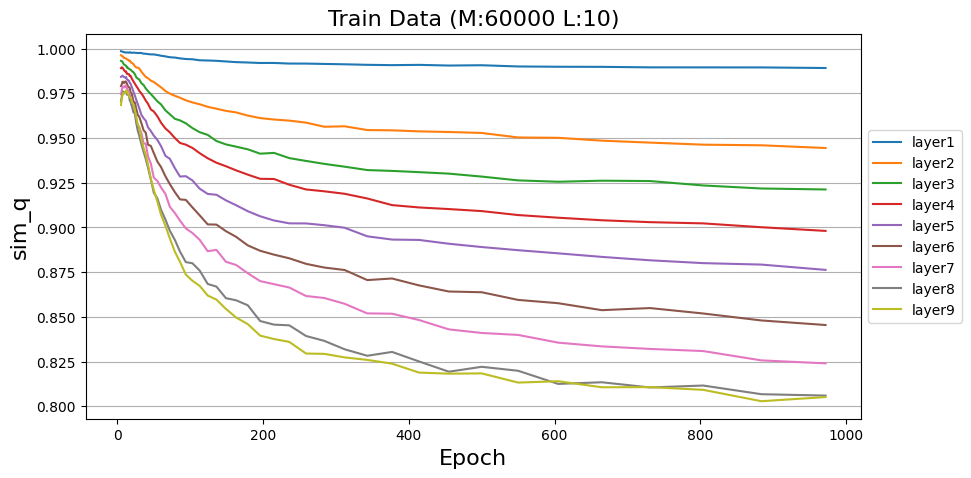

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
for i, l in enumerate(CFG.layer_name_list[:-1]):
    ax.plot(q2['time'][5:],q2[l][5:],label=f'layer{i+1}')
ax.set_xlabel('Epoch',fontsize=16)
ax.set_ylabel('sim_q', fontsize=16)
#ax.set_xscale('log')
ax.set_title(f'Train Data (M:{CFG.M} L:{CFG.L})',fontsize=16)
#ax.set_ylim(0,1)
ax.grid(axis='y')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
with open(f'./Output/Spin/M{CFG.M}/model001_stopW_type{CFG.ini_type}_L{CFG.L}_C{CFG.C}_{CFG.train}.txt','rb') as f:
    spin_A=pickle.loads(f.read())

with open(f'./Output/Spin/M{CFG.M}/model002_stopW_type{CFG.ini_type}_L{CFG.L}_C{CFG.C}_{CFG.train}.txt','rb') as f:
    spin_B=pickle.loads(f.read())

In [ ]:
spin_B['time']

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 22,
 24,
 26,
 28,
 30,
 33,
 36,
 39,
 42,
 46,
 50,
 55,
 60,
 66,
 72,
 79,
 86,
 94,
 103,
 113,
 124,
 136,
 149,
 163,
 179,
 196,
 215,
 236,
 259,
 284,
 312,
 343,
 377,
 414,
 455,
 500,
 550,
 605,
 665,
 731,
 804,
 884,
 972]